## Data Loading
First, I'll load the data and add some time columns that might come handy later

In [1]:
import pandas as pd
from datetime import datetime

glucose_path = "/home/resiemsual/xbird_Machine_Learning_Challenge/blood-glucose.csv"
step_count_path = "/home/resiemsual/xbird_Machine_Learning_Challenge/step-count.csv"

steps = pd.read_csv(step_count_path, names=["time_steps","steps"])
glucose_levels = pd.read_csv(glucose_path, names=["time_gl","gl"])

data = pd.merge(steps, glucose_levels, how='left', left_on=['time_steps'], right_on=['time_gl'])

In [2]:
def prepareData(data):
    data.time_steps = data.time_steps.astype("datetime64[ns]")
    data["steps_rolling"] = data["steps"].rolling(12).sum()
    
    data["minuteOfDay"] = data.time_steps.map(lambda time: time.hour*60+time.minute)
    data["hourOfDay"] = data.time_steps.map(lambda time: time.hour)
    data["dayTime"] = data.time_steps.map(lambda time: "%d:%d"%(time.hour,time.minute))
    data["day"] = data.time_steps.map(lambda time: time.day)
    
    data["isMorning"] = data.hourOfDay.map(lambda time: time > 6 and time <= 10).astype("int")
    data["isNoon"] = data.hourOfDay.map(lambda time: time >= 11 and time <= 13).astype("int")
    data["isEvening"] = data.hourOfDay.map(lambda time: time >= 19 and time <= 21).astype("int")

    data = data.set_index("time_steps")
    return data

data = prepareData(data)

## Trend by day
In order to get a feeling for the data, lets visualize the glucose levels by day. 
The levels can vary strongly. There seems to be something going on around 800 minutes (noon), 500 (morning) and may be later (1200), but its hard to tell with the naked eye.

In [3]:
data["isMorning"] = data.hourOfDay.map(lambda time: time > 6 and time <= 10).astype("int")
data["isNoon"] = data.hourOfDay.map(lambda time: time >= 11 and time <= 13).astype("int")
data["isEvening"] = data.hourOfDay.map(lambda time: time >= 19 and time <= 21).astype("int")

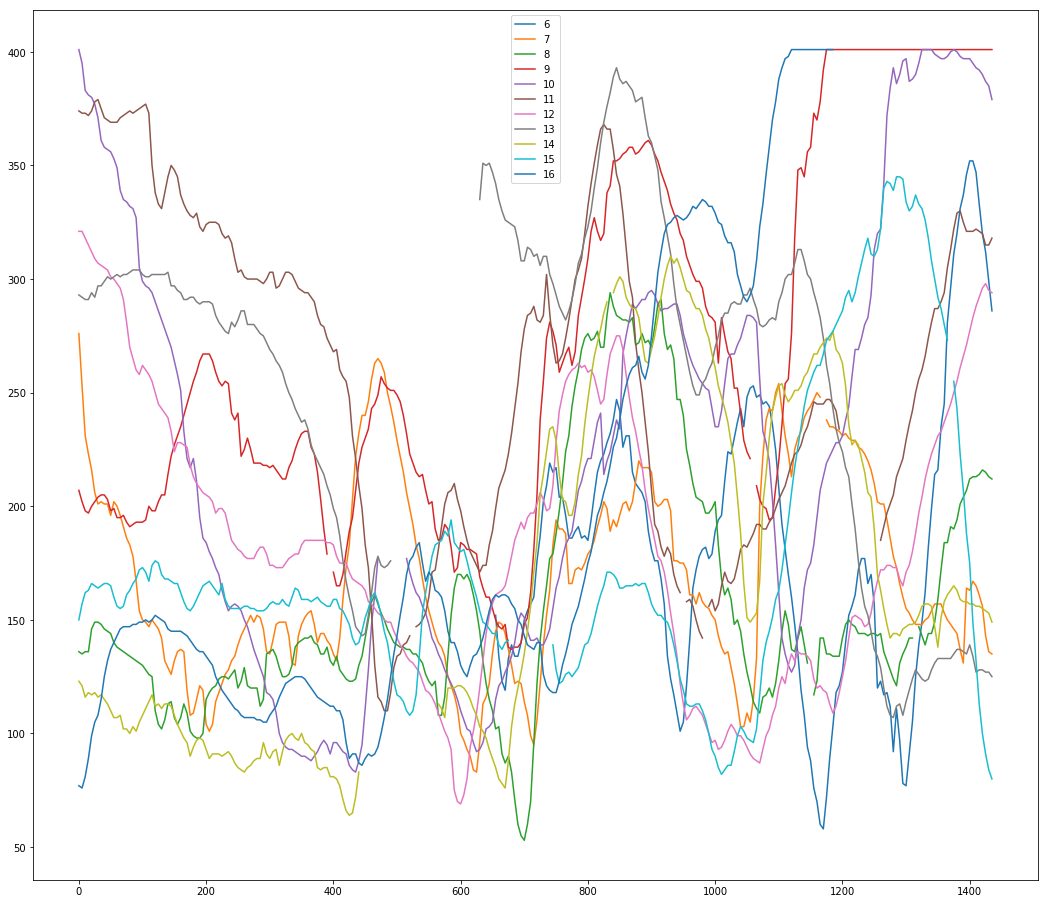

In [5]:
import pylab as plt 


days = data.day.unique()
fig=plt.figure(figsize=(18, 16))
for day in days:
    index = data["day"]==day
    plt.plot( data[ index][ "minuteOfDay" ], data[ index][ "gl" ], label=day )

plt.legend()

## The Model
I wand to fit an ARIMA model to the data using statsmodels. It does not seem that there is much autocorrelation going on here, thus i suspect that it will be more a moving average model.
I chose this model since it can handle various properties of time series models. Moreover, it is a probabilistic model which will be useful to estimate the probability that the blood sugar level will fall by 20mg/dL.

As soon as I have a model I will try to use it to answer the question: what is the probability the glucose level drops by 20mg/dL within 30 min?

We can use the model to calculate the likelihood of observing a value of at most CURRENT_VAL-20 in 30 min.

## Model Tests
I tried several models and several features. 
The time point (as hours(dummy coded), as interval) did not improve the model very much.
I spend acualy quite some time to investigate since it was supposadly importand but couldn`t find the reason.

In [6]:
from statsmodels.tsa.arima_model import ARIMA

n_train_data = 2500

data_noNa = data.dropna()
train_data = data_noNa[:n_train_data]
exogen_col_names = ["steps_rolling", "steps"] 

model = ARIMA( train_data.gl, order=(3, 0, 1), exog=train_data[exogen_col_names] )
fitted = model.fit()

/home/resiemsual/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
/home/resiemsual/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/home/resiemsual/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


/home/resiemsual/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/home/resiemsual/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/home/resiemsual/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


                              ARMA Model Results                              
Dep. Variable:                     gl   No. Observations:                 2500
Model:                     ARMA(3, 1)   Log Likelihood               -8221.398
Method:                       css-mle   S.D. of innovations              6.479
Date:                Thu, 10 May 2018   AIC                          16458.797
Time:                        10:28:21   BIC                          16505.389
Sample:                    11-06-2017   HQIC                         16475.712
                         - 11-15-2017                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           208.2221     13.879     15.003      0.000     181.020     235.424
steps_rolling    -0.0051      0.002     -3.210      0.001      -0.008      -0.002
steps             0.0035      0.002     

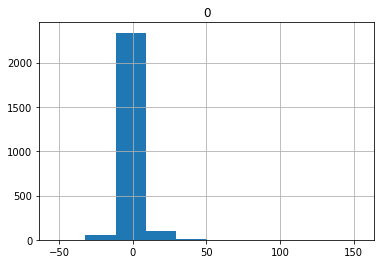

In [7]:
pd.DataFrame(fitted.resid).hist()
print(fitted.summary())
print(pd.DataFrame(fitted.resid).describe())

In [289]:
testData = data_noNa[n_train_data:]

## Prediction Method
This part is uncomplete as I failed to figure out how I could get proper estimates from statsmodels.
I didnt even figure out how it can use exogenous variables for the predict method. 
However, the predict method is not even what I needed. I wanted a function that returns the likelihoods of given values under the model. It appears this function doesn't exist and that I would have needed to write it on my own.

In [356]:
import datetime 

start = datetime.datetime(2017, 11, 6, 15,0 )
end = start  + datetime.timedelta(minutes = 30)

fitted.predict(start, end)

/home/resiemsual/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


time_steps
2017-11-06 15:00:00    182.357495
2017-11-06 15:05:00    175.468054
2017-11-06 15:10:00    171.604698
2017-11-06 15:15:00    174.905369
2017-11-06 15:20:00    164.623336
2017-11-06 15:25:00    150.971428
2017-11-06 15:30:00    122.486072
dtype: float64

# Conclusion
I failed to deliver an anwser to the question. 
Obviously I should have used a library that I know better, not statsmodels.
If I would need to do this again, my choice would have been much simpler. I would have used a simple logistic regression to predict if the blood sugar level would drop by 20mg/dL. This might have been not very smart, but at least i would have worked.